In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
% matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from hcnn.crchcnn import CRCHCNN
from hcnn.loss_functions import LogCosh

# Airline passengers data

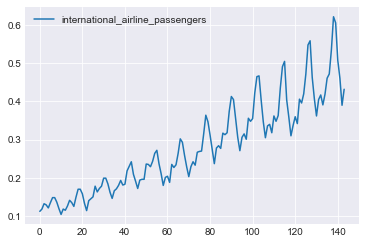

In [2]:
df = pd.read_csv('../data/international-airline-passengers.csv', index_col=0)
df.index = range(0, len(df))
df /= 1000
df.plot()

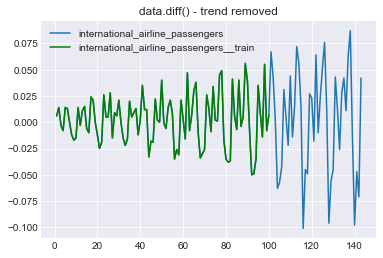

In [3]:
data = df.diff()  # remove trend
data = data.iloc[1:]
train_test_split_index = 100
data_train = data[:train_test_split_index]

fig, ax = plt.subplots()
data.plot(ax=ax, title='data.diff() - trend removed')
data_train.rename(columns={c:'{}__train'.format(c) for c in data_train.columns}).plot(ax=ax, color='g')
plt.show()

In [4]:
crchcnn = CRCHCNN(data_dim=data.shape[1], hidden_dim=50, sparsity=0.3, weight_std=0.1, forecast_horizon=data_train.shape[0])

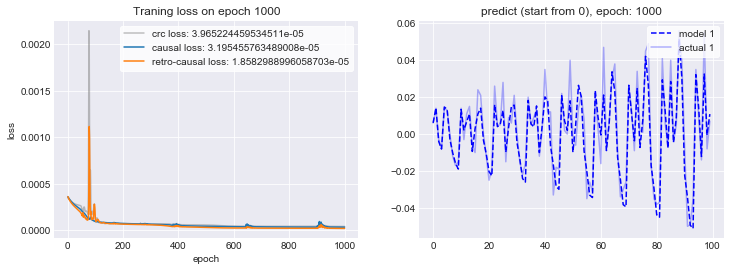

In [5]:
train_loss = crchcnn.train(
    data_train.values, 
    lr=0.0005, epochs=1000, 
    criterion=LogCosh.apply, 
    plot_pred_train=True
)

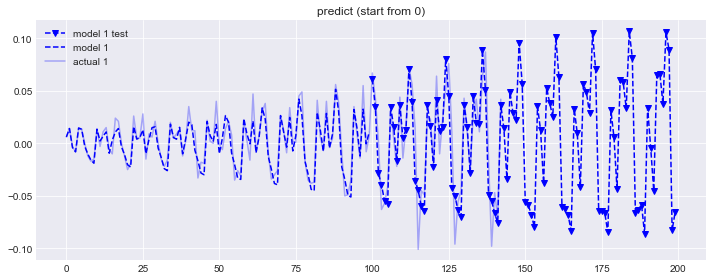

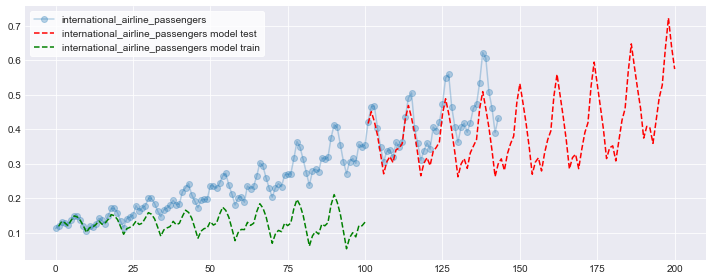

In [8]:
y_pred = crchcnn.sample(
    state_c=crchcnn.hcnn_c.hcnn.init_state, 
    state_rc=crchcnn.hcnn_rc.forward(crchcnn.hcnn_rc.hcnn.init_state, crchcnn.forecast_horizon),
)
y_pred_test = crchcnn.sample(
    state_c=crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data_train)), 
    state_rc=crchcnn.hcnn_rc.hcnn.init_state,
)

# PLOT forecast of diffs
fig, ax = plt.subplots(figsize=(10, 4))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(y_pred_test.shape[0]) + data_train.shape[0], y_pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
    ax.plot(y_pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data.values[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

# PLOT FORECAST after diff inverse transform
def diff_inverse_transform(df, first_row):
    df_ = first_row
    for i in range(df.shape[0]):
        row = pd.DataFrame(data=df.iloc[[i]].values + df_.iloc[[i]].values, 
                           columns=df.columns, index=df.iloc[[i]].index)
        df_ = df_.append(row)
    return df_.iloc[1:]

y_pred_test = pd.DataFrame(data=y_pred_test, columns=df.columns)#.rename('forecast from the end of train'])
y_pred_test.index = np.arange(data_train.index[-1]+1, data_train.index[-1]+1+crchcnn.forecast_horizon)
df_forecast_test = diff_inverse_transform(y_pred_test, df.loc[[data_train.index[-1]]])
df_forecast_test.rename(columns={c: '{} model test'.format(c) for c in df_forecast_test.columns}, inplace=True)

y_pred = pd.DataFrame(data=y_pred, columns=df.columns, index=np.arange(data_train.index[0], data_train.index[0]+crchcnn.forecast_horizon)) # columns=['forecast from the start']
df_forecast = diff_inverse_transform(y_pred, df.loc[[0]])
df_forecast.rename(columns={c: '{} model train'.format(c) for c in df_forecast.columns}, inplace=True)
    
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(ax=ax, style='o-', alpha=0.3)
df_forecast_test.plot(ax=ax, style='r--')
df_forecast.plot(ax=ax, style='g--')
legend_pred = ax.legend(frameon=True, loc='upper left')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

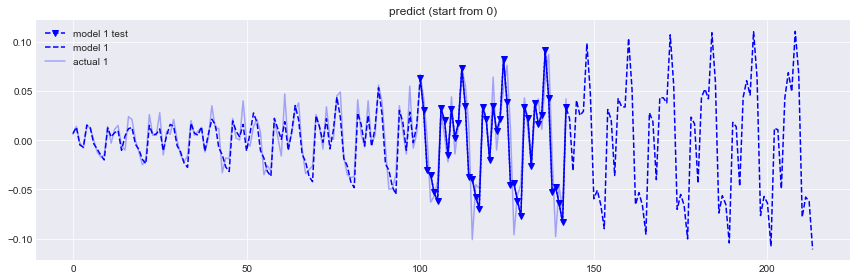

In [9]:
# Forecast with causal hcnn (of trained CRC-HCNN)
pred = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.hcnn.init_state, int(len(data)*1.5))
pred_test = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data_train)), int(len(data) - len(data_train)))

fig, ax = plt.subplots(figsize=(12, 4))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(np.arange(pred_test.shape[0]) + data_train.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
    ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data.values[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

# Macro data

In [24]:
macro = pd.read_csv('../data/macro.csv', index_col=0)
macro_train = macro.iloc[:-15]
print(f'Train: {len(macro_train)} (obs.)')

Train: 45 (obs.)


In [25]:
crchcnn = CRCHCNN(data_dim=macro.shape[1], hidden_dim=500, sparsity=0.99, weight_std=0.3, forecast_horizon=macro_train.shape[0])

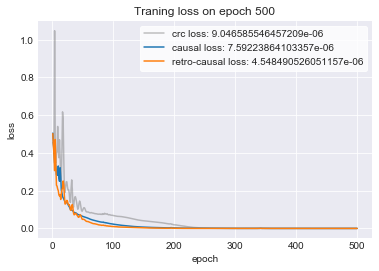

In [26]:
train_loss = crchcnn.train(
    macro_train.values, 
    lr=0.0005, epochs=500, 
    criterion=LogCosh.apply, 
    plot_loss=True, plot_pred_train=False, verbose=False
)

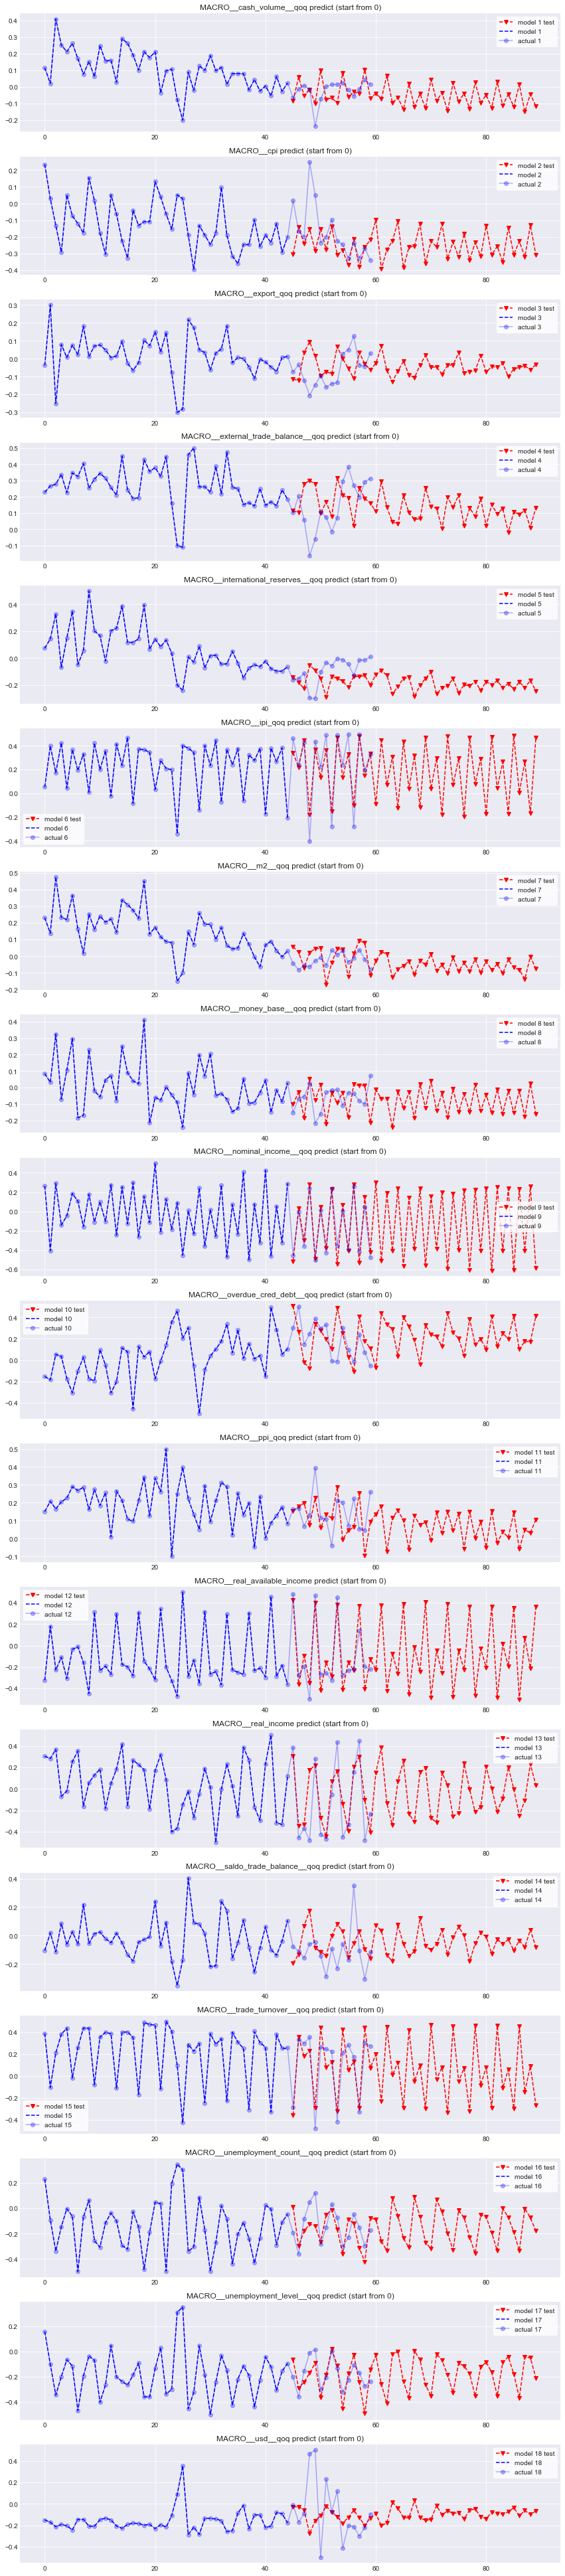

In [27]:
pred = crchcnn.sample(
    state_c=crchcnn.hcnn_c.hcnn.init_state, 
    state_rc=crchcnn.hcnn_rc.forward(crchcnn.hcnn_rc.hcnn.init_state, crchcnn.forecast_horizon),
)
pred_test = crchcnn.sample(
    state_c=crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(macro_train)), 
    state_rc=crchcnn.hcnn_rc.hcnn.init_state,
)

fig, ax = plt.subplots(figsize=(12, 3*macro.shape[1]), nrows=macro.shape[1])
for c in range(macro.shape[1]):
    ax[c].plot(np.arange(pred_test.shape[0]) + macro_train.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color='red', alpha=1)
    ax[c].plot(pred[:, c], '--', label=f'model {c+1}', color='blue', alpha=1)
    ax[c].plot(macro.values[:, c], 'o-', label=f'actual {c+1}', color='blue', alpha=0.3)
    ax[c].set_title(f'{macro.columns[c]} predict (start from 0)')
    legend_pred = ax[c].legend(frameon=True)
    legend_pred.get_frame().set_color('white')
plt.tight_layout()